In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: 34.5260 - mae: 0.9604 - val_loss: 30.0126 - val_mae: 0.3355 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 28.9663 - mae: 0.7054 - val_loss: 24.9155 - val_mae: 0.3312 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 23.9979 - mae: 0.5799 - val_loss: 20.7844 - val_mae: 0.3116 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 20.0435 - mae: 0.5145 - val_loss: 17.4870 - val_mae: 0.2940 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 16.9162 - mae: 0.4934 - val_loss: 14.8514 - val_mae: 0.2855 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 14.3821 - mae: 0.4574 - val_loss: 12.7053 - val_mae: 0.2393 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 12.3273 - mae: 0.4078 - val_loss: 10.9252 - val_mae: 0.2136 - learning_rate

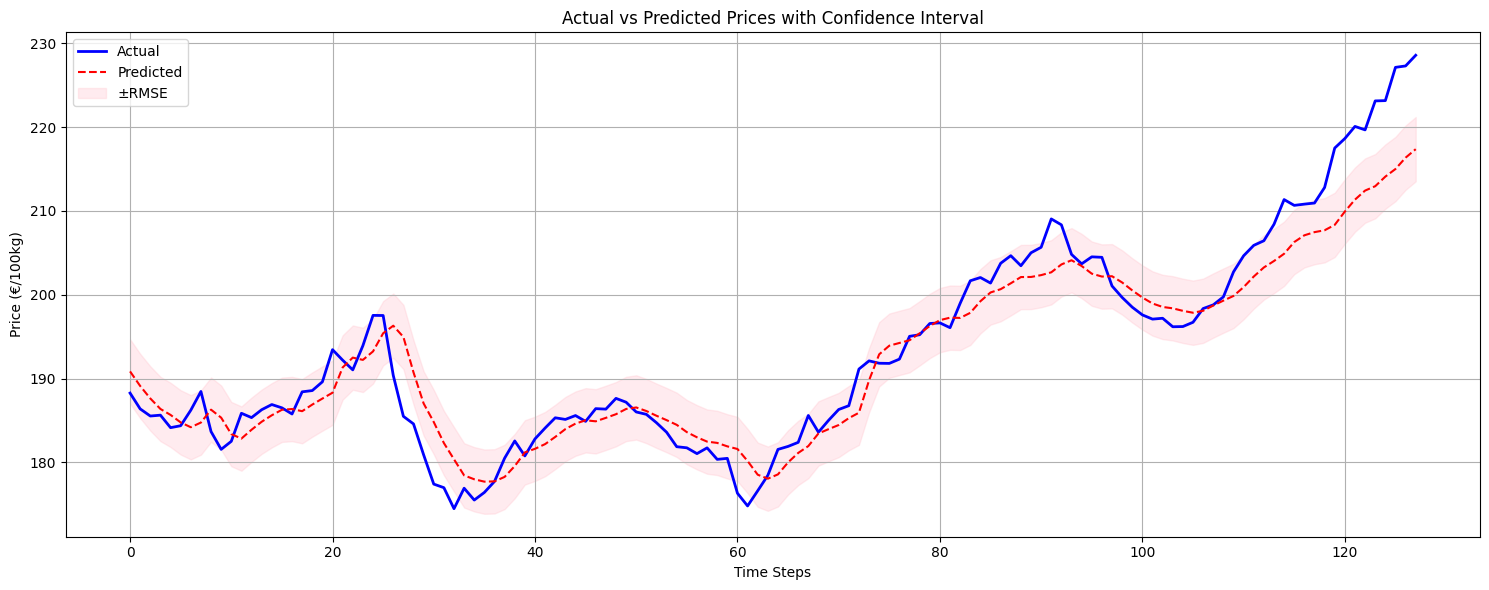

['feature_scaler.pkl']

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.losses import Huber
import tensorflow as tf
import joblib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --------------------------
# STEP 1: Enhanced Data Preparation
# --------------------------
TARGET = 'Price (€/100kg)'
FORECAST_HORIZON = 1
WINDOW_SIZE = 8  # Reduced from 16 to prevent overfitting

# Load and prepare data
data = pd.read_excel('/kaggle/input/eu-broiler-price-dataset/merged_dataset_2.xlsx', index_col='End Date', parse_dates=True)

# Improved feature engineering
def add_features(df):
    df = df.copy()
    
    # Lag features with different intervals
    for lag in [1, 2, 4, 8]:
        df[f'{TARGET}_lag{lag}'] = df[TARGET].shift(lag)
    
    # Rolling features with different windows
    for window in [4, 8]:
        df[f'Price_rolling_mean_{window}'] = df[TARGET].shift(1).rolling(window=window).mean()
        df[f'Price_rolling_std_{window}'] = df[TARGET].shift(1).rolling(window=window).std()
    
    # Seasonality features
    df['week_of_year'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['quarter_sin'] = np.sin(2 * np.pi * df.index.quarter/4)
    df['quarter_cos'] = np.cos(2 * np.pi * df.index.quarter/4)
    
    # Remove outliers using IQR
    Q1 = df[TARGET].quantile(0.25)
    Q3 = df[TARGET].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[TARGET] < (Q1 - 1.5 * IQR)) | (df[TARGET] > (Q3 + 1.5 * IQR)))]
    
    df.dropna(inplace=True)
    return df

data = add_features(data)

# Feature selection based on correlation
corr_matrix = data.corr()
target_corr = corr_matrix[TARGET].abs().sort_values(ascending=False)
selected_features = target_corr[target_corr > 0.3].index.tolist()
if TARGET not in selected_features:
    selected_features.append(TARGET)

data = data[selected_features]

# --------------------------
# STEP 2: Improved Data Scaling and Splitting
# --------------------------
# Use RobustScaler for better outlier handling
scaler = RobustScaler()
train_size = int(len(data) * 0.8)  # Increased training size
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Scale all features together to maintain relationships
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# ------------------------------
# STEP 3: Enhanced Model Architecture
# ------------------------------
def build_improved_gru(input_shape):
    model = Sequential([
        Input(shape=input_shape),  # Explicit input layer
        GRU(64, return_sequences=True, 
           kernel_regularizer=l1_l2(l1=0.01, l2=0.01),
           recurrent_regularizer=l1_l2(l1=0.01, l2=0.01),
           kernel_initializer=HeNormal(seed=42)),
        BatchNormalization(),
        Dropout(0.3),
        
        GRU(32, 
           kernel_regularizer=l1_l2(l1=0.01, l2=0.01),
           recurrent_regularizer=l1_l2(l1=0.01, l2=0.01),
           kernel_initializer=HeNormal(seed=42)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu', kernel_initializer=HeNormal(seed=42)),
        Dense(1)
    ])
    
    optimizer = Nadam(learning_rate=0.001, clipvalue=0.5)
    model.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])
    return model

# Create sequences with reduced window size
def create_sequences(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+forecast_horizon-1, 0])  # Target is first column
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE, FORECAST_HORIZON)
X_test, y_test = create_sequences(test_scaled, WINDOW_SIZE, FORECAST_HORIZON)

# --------------------------
# STEP 4: Robust Model Training
# --------------------------
model = build_improved_gru((WINDOW_SIZE, X_train.shape[2]))

callbacks = [
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, min_delta=0.001),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20),
    ModelCheckpoint('best_gru_model.h5', monitor='val_loss', save_best_only=True)
]

# Add validation split from training data
val_size = int(0.2 * len(X_train))
X_train_final, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_final, y_val = y_train[:-val_size], y_train[-val_size:]

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

# --------------------------
# STEP 5: Comprehensive Evaluation
# --------------------------
model.load_weights('best_gru_model.h5')

def inverse_transform(y, scaler, feature_index=0):
    dummy = np.zeros((len(y), train_data.shape[1]))
    dummy[:, feature_index] = y
    return scaler.inverse_transform(dummy)[:, feature_index]

# Predictions
y_pred_train = model.predict(X_train_final).flatten()
y_pred_test = model.predict(X_test).flatten()

# Inverse scaling
y_train_inv = inverse_transform(y_train_final, scaler)
y_test_inv = inverse_transform(y_test, scaler)
y_pred_train_inv = inverse_transform(y_pred_train, scaler)
y_pred_test_inv = inverse_transform(y_pred_test, scaler)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'R2': r2_score(y_true, y_pred)
    }
    return metrics

train_metrics = calculate_metrics(y_train_inv, y_pred_train_inv)
test_metrics = calculate_metrics(y_test_inv, y_pred_test_inv)

print("\nTraining Metrics:", train_metrics)
print("Test Metrics:", test_metrics)

# Enhanced visualization
plt.figure(figsize=(15, 6))
plt.plot(y_test_inv, label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_test_inv, label='Predicted', color='red', linestyle='--')
plt.fill_between(range(len(y_test_inv)), 
                y_pred_test_inv - test_metrics['RMSE'], 
                y_pred_test_inv + test_metrics['RMSE'],
                color='pink', alpha=0.3, label='±RMSE')
plt.title('Actual vs Predicted Prices with Confidence Interval')
plt.ylabel('Price (€/100kg)')
plt.xlabel('Time Steps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('final_prediction.png', dpi=300)
plt.show()

# Save model and scalers
model.save('broiler_price_gru_model.keras')
joblib.dump(scaler, 'feature_scaler.pkl')

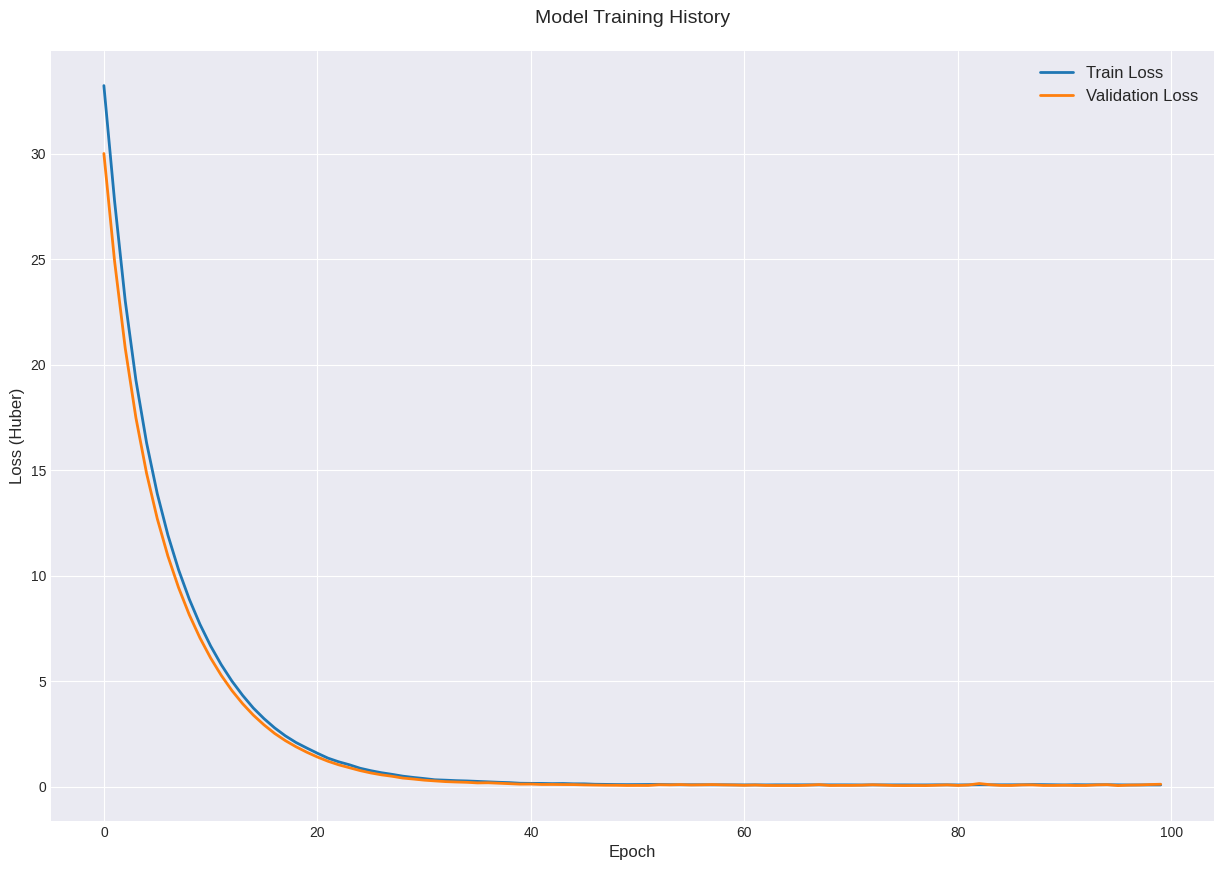

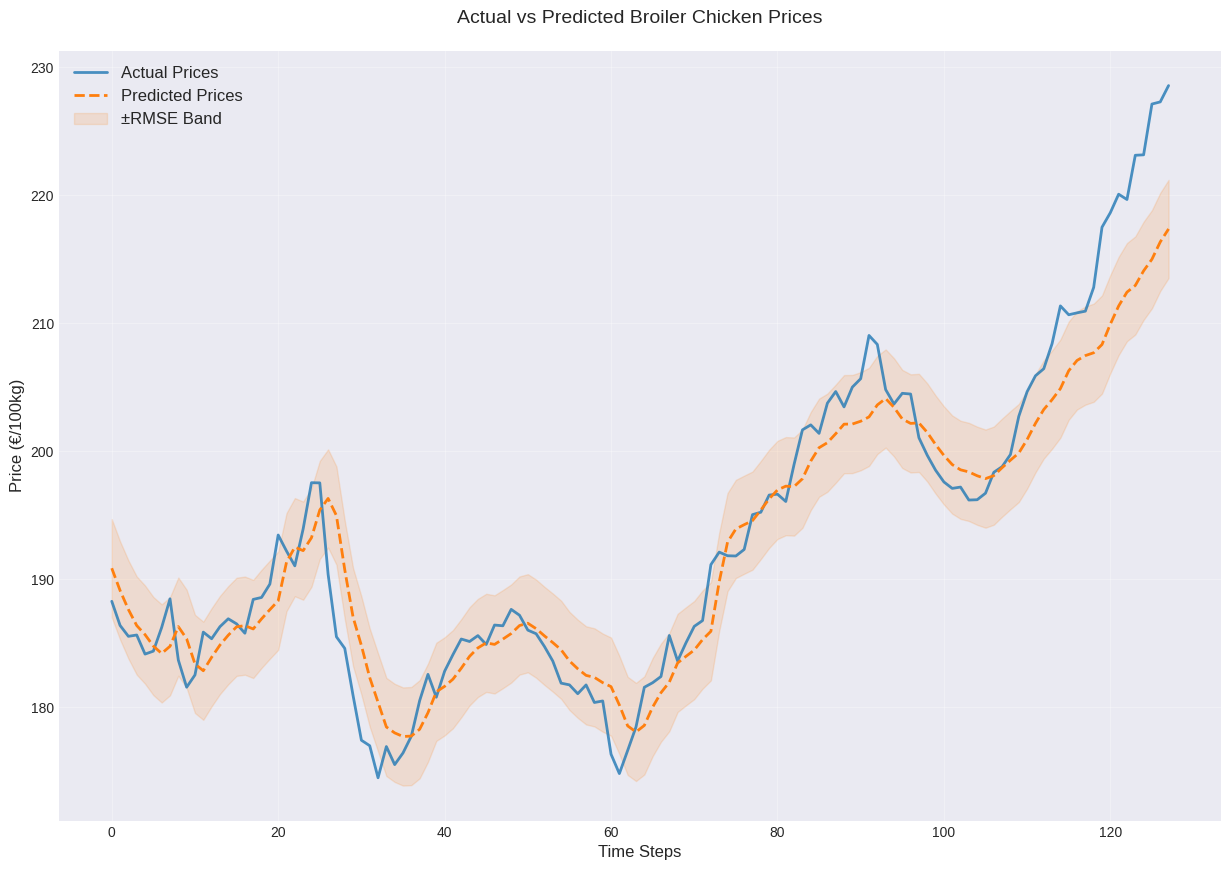

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


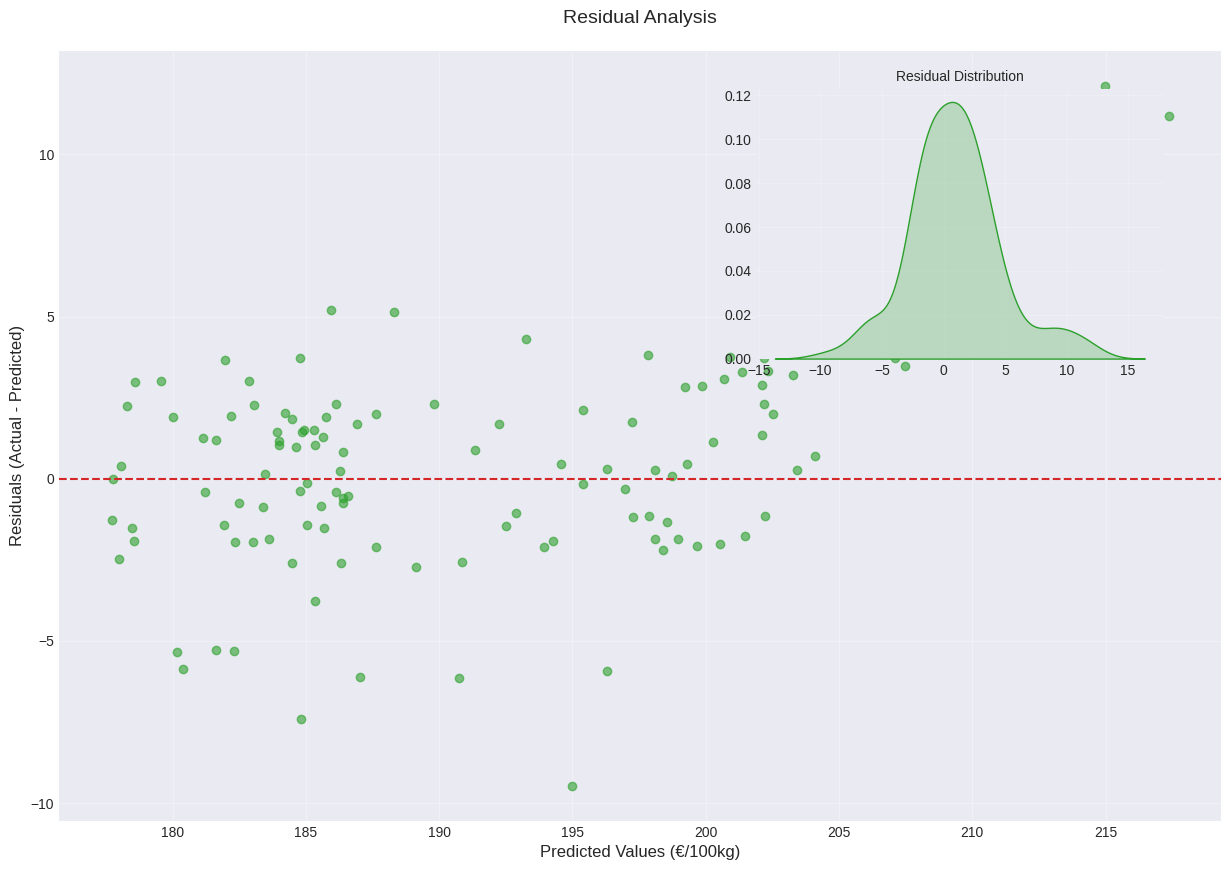

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


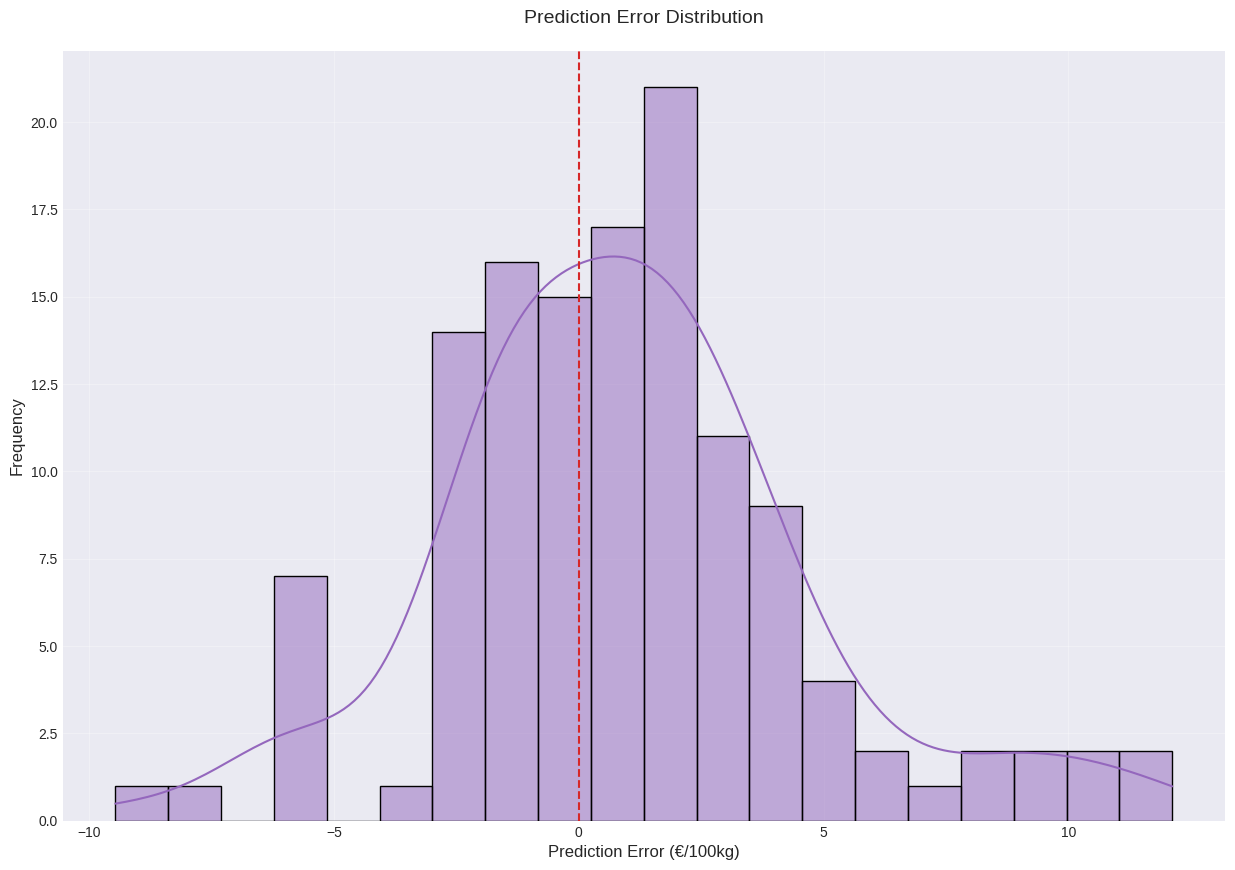

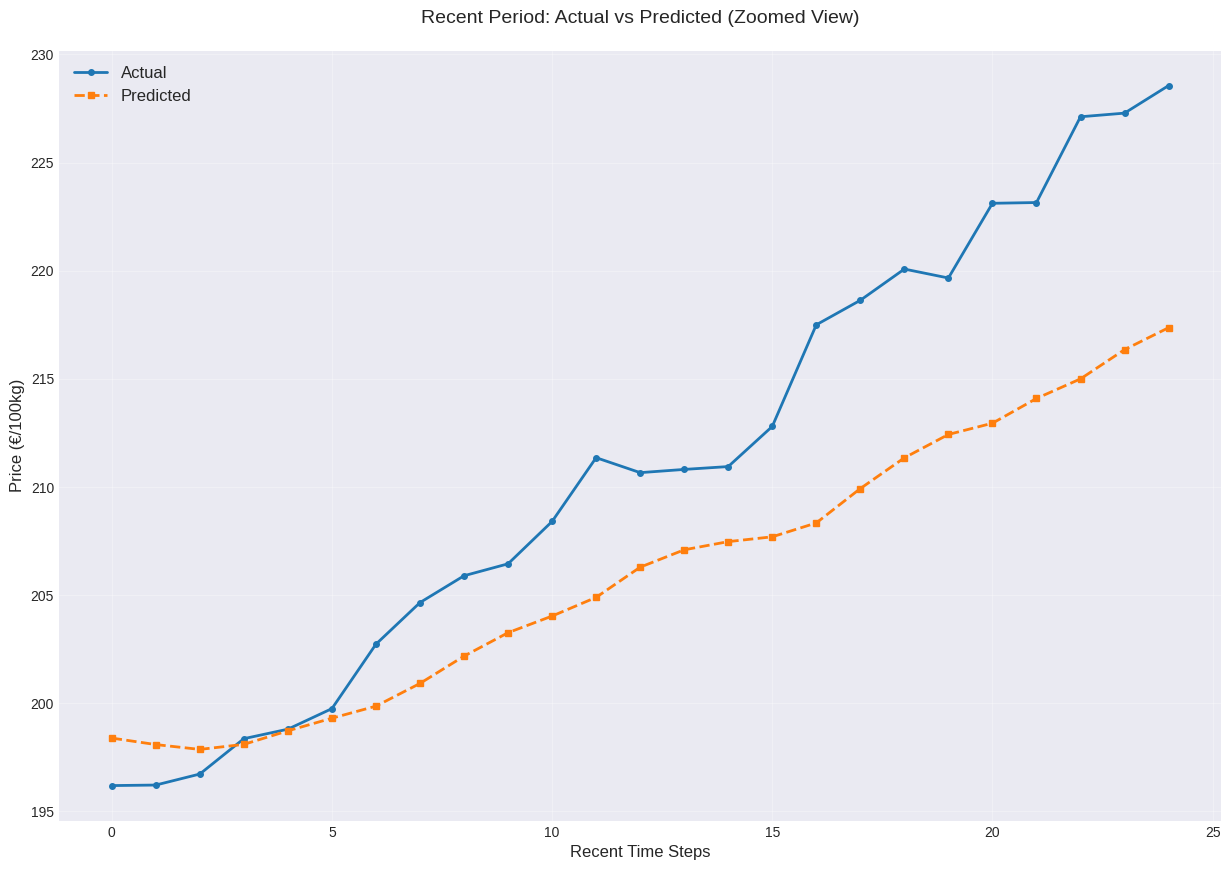

In [7]:
# --------------------------
# Enhanced Visualization Section
# --------------------------

# Set the style for better looking plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [15, 10]

# 1. Training History Plot
plt.figure()
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Training History', fontsize=14, pad=20)
plt.ylabel('Loss (Huber)', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# 2. Actual vs Predicted Prices Plot
plt.figure()
plt.plot(y_test_inv, label='Actual Prices', color='#1f77b4', linewidth=2, alpha=0.8)
plt.plot(y_pred_test_inv, label='Predicted Prices', color='#ff7f0e', linestyle='--', linewidth=2)
plt.fill_between(range(len(y_test_inv)), 
                y_pred_test_inv - test_metrics['RMSE'], 
                y_pred_test_inv + test_metrics['RMSE'],
                color='#ff7f0e', alpha=0.15, label='±RMSE Band')
plt.title('Actual vs Predicted Broiler Chicken Prices', fontsize=14, pad=20)
plt.ylabel('Price (€/100kg)', fontsize=12)
plt.xlabel('Time Steps', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Residual Analysis Plot
plt.figure()
residuals = y_test_inv - y_pred_test_inv
plt.scatter(y_pred_test_inv, residuals, alpha=0.6, color='#2ca02c')
plt.axhline(y=0, color='#d62728', linestyle='--', linewidth=1.5)
plt.title('Residual Analysis', fontsize=14, pad=20)
plt.xlabel('Predicted Values (€/100kg)', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add residual distribution on the side
ax = plt.gca()
ax_hist = ax.inset_axes([0.6, 0.6, 0.35, 0.35])
sns.kdeplot(residuals, ax=ax_hist, color='#2ca02c', fill=True)
ax_hist.set_title('Residual Distribution', fontsize=10)
ax_hist.set_xlabel('')
ax_hist.set_ylabel('')
ax_hist.grid(True, alpha=0.2)
plt.show()

# 4. Error Distribution Plot
plt.figure()
sns.histplot(residuals, kde=True, color='#9467bd', bins=20, alpha=0.5)
plt.axvline(x=0, color='#d62728', linestyle='--', linewidth=1.5)
plt.title('Prediction Error Distribution', fontsize=14, pad=20)
plt.xlabel('Prediction Error (€/100kg)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# 5. Zoomed-in Comparison Plot (last 20% of test data)
zoom_length = int(len(y_test_inv) * 0.2)
plt.figure()
plt.plot(y_test_inv[-zoom_length:], label='Actual', color='#1f77b4', marker='o', markersize=4, linewidth=2)
plt.plot(y_pred_test_inv[-zoom_length:], label='Predicted', color='#ff7f0e', marker='s', markersize=4, linestyle='--', linewidth=2)
plt.title('Recent Period: Actual vs Predicted (Zoomed View)', fontsize=14, pad=20)
plt.ylabel('Price (€/100kg)', fontsize=12)
plt.xlabel('Recent Time Steps', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
%pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
